# Examen Pratique Fil Rouge – Deep Learning IA2

In [1]:

import urllib.request, zipfile, os
url = "https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip"
zip_path = "caltech101.zip"
urllib.request.urlretrieve(url, zip_path)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("data_caltech101/")
print("Dataset ready in ./data_caltech101/")


Dataset ready in ./data_caltech101/


## 1.2 – Structure du dataset

Dans cette section, on explore l’arborescence du dossier extrait, on compte le nombre
de classes, et on affiche quelques exemples de classes.


In [ ]:
import os

base = "data_caltech101"
os.makedirs(base, exist_ok=True)

# cherche tous les dossiers nommés 101_ObjectCategories (ou variantes) sous base
candidates = []
for root, dirs, files in os.walk(base):
    for d in dirs:
        name = d.lower()
        if "101_objectcategories" in name or "101-objectcategories" in name or name.startswith("101_object"):
            candidates.append(os.path.join(root, d))

if not candidates:
    print("Aucun dossier '101_ObjectCategories' trouvé sous", base)
    print("Contenu de", base, ":", os.listdir(base) if os.path.exists(base) else "n'existe pas")
    data_dir = None
    classes = []
else:
    # choisis le candidat ayant le plus de sous-dossiers (probablement le bon niveau contenant les classes)
    def n_subdirs(path):
        try:
            return sum(1 for x in os.listdir(path) if os.path.isdir(os.path.join(path, x)))
        except Exception:
            return 0
    best = max(candidates, key=n_subdirs)
    # si le meilleur contient à son tour un dossier du même nom, descendre d'un niveau
    nested_same = os.path.join(best, os.path.basename(best))
    if os.path.isdir(nested_same) and n_subdirs(nested_same) > n_subdirs(best):
        best = nested_same

    data_dir = best
    # Exclure les dossiers 'background' (ex: 'BACKGROUND_Google') des classes si souhaité
    classes = sorted([d for d in os.listdir(data_dir)
                      if os.path.isdir(os.path.join(data_dir, d))
                      and not d.lower().startswith('background')])
    print("Dossier utilisé :", data_dir)
    print("Nombre total de classes :", len(classes))
    print("Exemples de classes :", classes[:10])


Dossier utilisé : data_caltech101\caltech-101\101_ObjectCategories
Nombre total de classes : 102
Exemples de classes : ['BACKGROUND_Google', 'Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel']


## 1.4 – Visualisation d'images

Affichage de quelques images choisies aléatoirement dans plusieurs classes.
Objectif : observer la variabilité visuelle (taille, contraste, position, etc.)


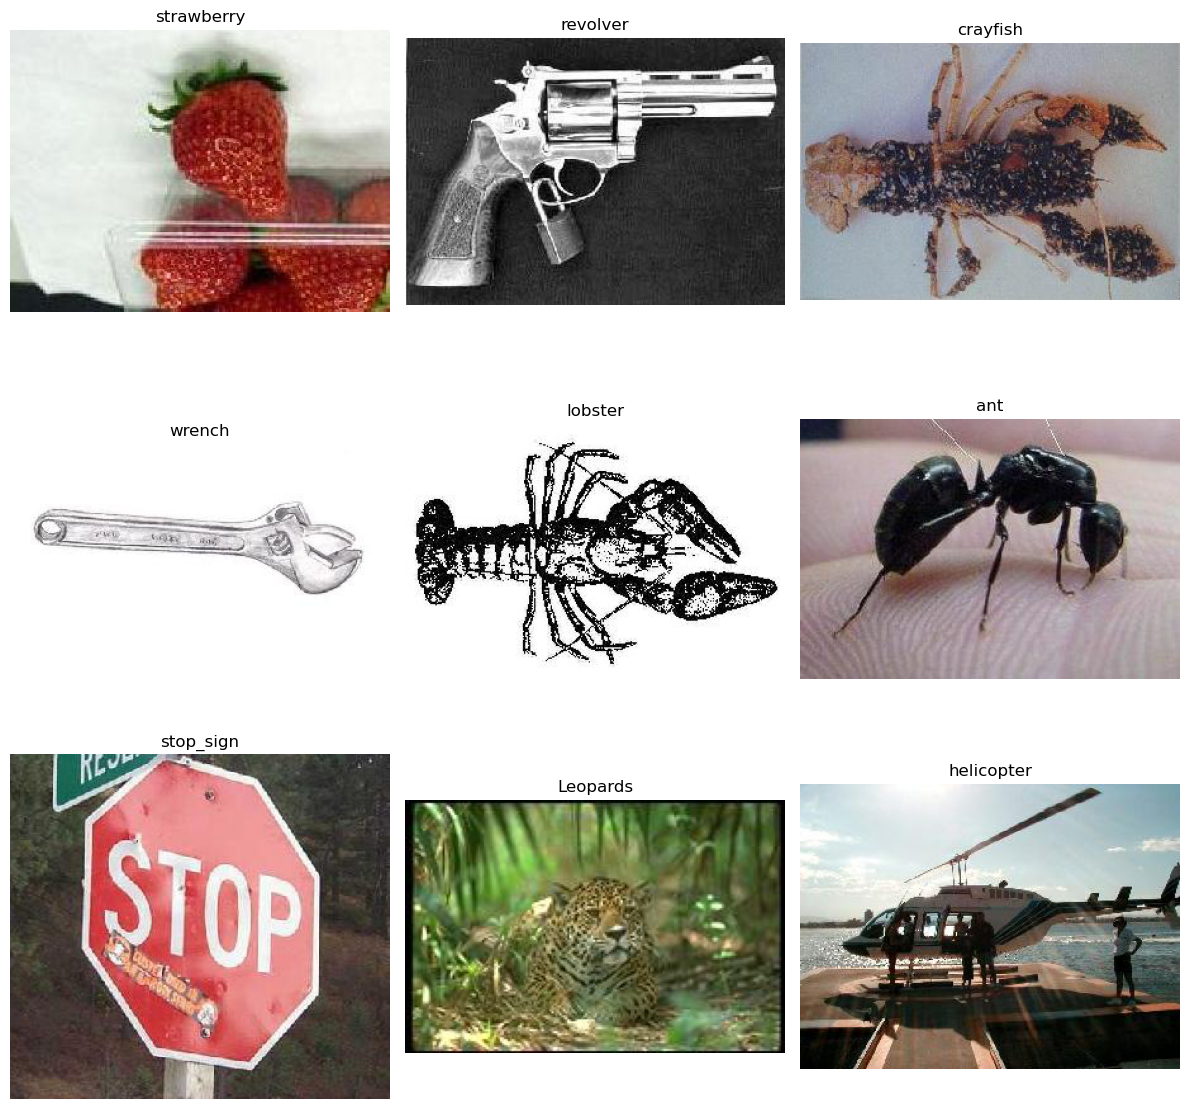

In [3]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# vérifie que data_dir et classes existent
if 'data_dir' not in globals() or data_dir is None or not classes:
    print("Erreur : 'data_dir' ou 'classes' non définis. Exécutez la cellule qui prépare le dataset.")
else:
    plt.figure(figsize=(12,12))
    valid_ext = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')
    count = 0
    attempts = 0
    # on essaie de récupérer jusqu'à 9 images valides (max 100 tentatives pour éviter boucle infinie)
    while count < 9 and attempts < 100:
        attempts += 1
        cls = random.choice(classes)
        cls_path = os.path.join(data_dir, cls)
        if not os.path.isdir(cls_path):
            continue
        imgs = [f for f in os.listdir(cls_path) if f.lower().endswith(valid_ext)]
        if not imgs:
            continue
        img_name = random.choice(imgs)
        img_path = os.path.join(cls_path, img_name)
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception:
            continue
        plt.subplot(3,3,count+1)
        plt.imshow(np.asarray(img))
        plt.title(cls)
        plt.axis("off")
        img.close()
        count += 1

    if count == 0:
        print("Aucune image valide trouvée dans les classes. Vérifie le contenu de", data_dir)
    plt.tight_layout()
    plt.show()

## 2.1 – Choix de la résolution d'entrée

Nous redimensionnons toutes les images à une résolution choisie (ex : 128×128).
Justification : compromis entre coût de calcul et préservation des détails.


In [4]:
IMG_SIZE = 128


## 2.2 – Normalisation

Nous normalisons les pixels dans [0,1] pour stabiliser l’entraînement.


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)


## 2.3 – Train/Validation/Test split

Nous utilisons un split 80% / 20%, stratifié via ImageDataGenerator (par classes).


In [6]:
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset="training"
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    subset="validation"
)


Found 7356 images belonging to 102 classes.
Found 1788 images belonging to 102 classes.


## 3.1 – Modèle MLP baseline

Nous construisons un MLP simple après flatten.


In [7]:
from tensorflow.keras import models, layers

model_mlp = models.Sequential([
    layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model_mlp.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_mlp.summary()


c:\Users\enzol\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │        52,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,218,662 (96.20 MB)

 Trainable params: 25,218,662 (96.20 MB)

 Non-trainable params: 0 (0.00 B)

## 3.2 – Entraînement et courbes

In [8]:
history_mlp = model_mlp.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


c:\Users\enzol\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - accuracy: 0.1254 - loss: 23.2165 - val_accuracy: 0.1806 - val_loss: 4.0602
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.2217 - loss: 3.7729 - val_accuracy: 0.2097 - val_loss: 3.7181
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.2228 - loss: 3.7185 - val_accuracy: 0.2332 - val_loss: 3.5588
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.2415 - loss: 3.5351 - val_accuracy: 0.2584 - val_loss: 3.5710
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.2704 - loss: 3.3561 - val_accuracy: 0.2260 - val_loss: 3.6184
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.2645 - loss: 3.3818 - val_accuracy: 0.2713 - val_loss: 3.4646
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.2806 - loss: 3.2668 - val_accuracy: 0.2595 - val_loss: 3.5144
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.2926 - loss: 3.1855

## Courbes d'entraînement du MLP

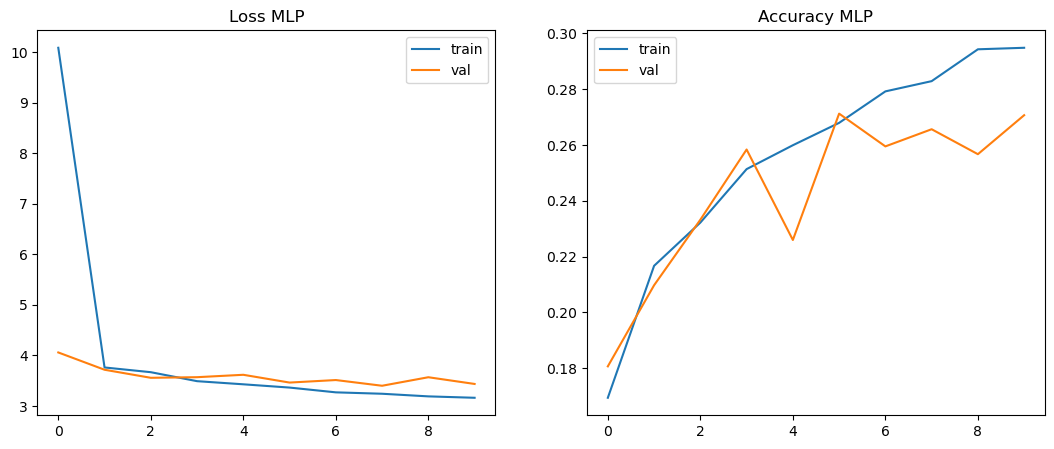

In [9]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(history_mlp.history['loss'], label="train")
plt.plot(history_mlp.history['val_loss'], label="val")
plt.legend()
plt.title("Loss MLP")

plt.subplot(1,2,2)
plt.plot(history_mlp.history['accuracy'], label="train")
plt.plot(history_mlp.history['val_accuracy'], label="val")
plt.legend()
plt.title("Accuracy MLP")

plt.show()


## 4.1 – CNN simple

Architecture CNN classique : Conv → Pool → Conv → Pool → Dense.


In [10]:
model_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()


c:\Users\enzol\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 102)            │        13,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,405,478 (28.25 MB)

 Trainable params: 7,405,478 (28.25 MB)

 Non-trainable params: 0 (0.00 B)

### 4.2 – Entraînement du CNN

In [11]:
history_cnn = model_cnn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


Epoch 1/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.2224 - loss: 3.8692 - val_accuracy: 0.3865 - val_loss: 2.9219
Epoch 2/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.4589 - loss: 2.3934 - val_accuracy: 0.4676 - val_loss: 2.4024
Epoch 3/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.6801 - loss: 1.3311 - val_accuracy: 0.4810 - val_loss: 2.4868
Epoch 4/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.8289 - loss: 0.6810 - val_accuracy: 0.5011 - val_loss: 2.7493
Epoch 5/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.9345 - loss: 0.2579 - val_accuracy: 0.4983 - val_loss: 3.2995
Epoch 6/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.9712 - loss: 0.1319 - val_accuracy: 0.4961 - val_loss: 3.6375
Epoch 7/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9900 - loss: 0.0536 - val_accuracy: 0.5134 - val_loss: 3.8416
Epoch 8/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9966 - loss: 0.0254 - 

### 4.3 – Matrice de confusion

56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


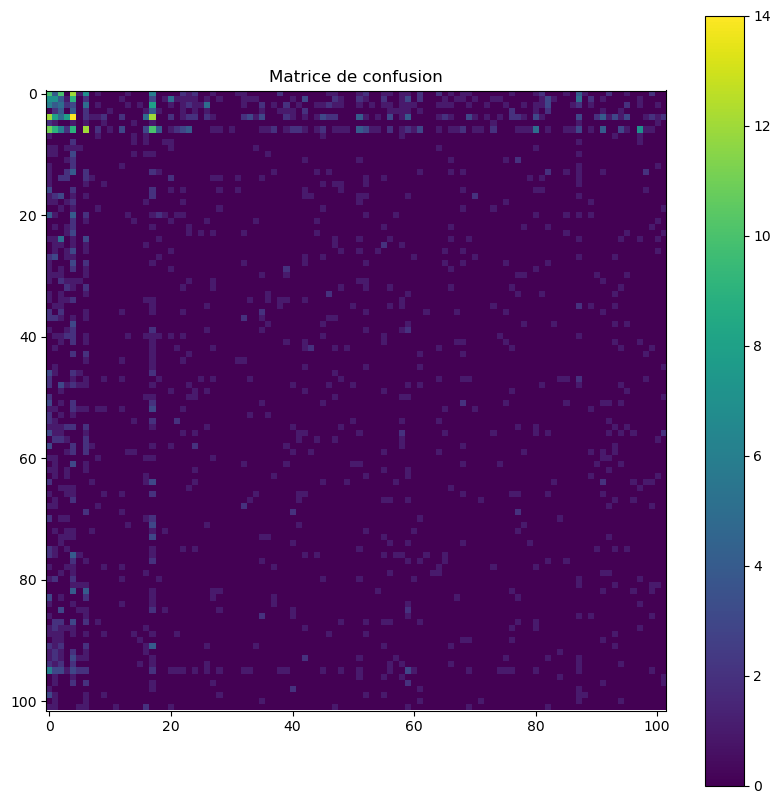

In [12]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Prédictions
y_true = val_gen.classes
y_pred = model_cnn.predict(val_gen).argmax(axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,10))
plt.imshow(cm)
plt.title("Matrice de confusion")
plt.colorbar()
plt.show()


## 5 – Étude d'ablation

Nous testons plusieurs variantes :
- Dropout
- Batch Normalization
- Data augmentation
- Learning rate modifié
Dans cellule qui suit exemple avec dropout


Dropout :

In [13]:
from tensorflow.keras import models, layers, optimizers


model_drop = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(classes), activation='softmax')
])

model_drop.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_drop = model_drop.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


c:\Users\enzol\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Variante 1 – CNN avec Batch Normalization

Objectif : stabiliser et accélérer l’entraînement en normalisant les activations de chaque couche convolutionnelle.
Hypothèse : meilleure convergence, réduction du surapprentissage.


In [14]:
from tensorflow.keras import models, layers, optimizers

model_bn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(classes), activation='softmax')
])

model_bn.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_bn = model_bn.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


Epoch 1/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 36s 152ms/step - accuracy: 0.3351 - loss: 3.3555 - val_accuracy: 0.1488 - val_loss: 4.2715
Epoch 2/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 35s 150ms/step - accuracy: 0.6723 - loss: 1.5116 - val_accuracy: 0.2534 - val_loss: 3.5491
Epoch 3/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 37s 159ms/step - accuracy: 0.9500 - loss: 0.3710 - val_accuracy: 0.5459 - val_loss: 1.9975
Epoch 4/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 35s 154ms/step - accuracy: 0.9967 - loss: 0.0585 - val_accuracy: 0.5749 - val_loss: 1.9338
Epoch 5/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 35s 151ms/step - accuracy: 0.9987 - loss: 0.0239 - val_accuracy: 0.6040 - val_loss: 1.7453
Epoch 6/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 35s 150ms/step - accuracy: 0.9989 - loss: 0.0089 - val_accuracy: 0.6091 - val_loss: 1.7390
Epoch 7/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step - accuracy: 0.9991 - loss: 0.0074 - val_accuracy: 0.6079 - val_loss: 1.7483
Epoch 8/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 36s 155ms/step - accuracy: 0.9991 - loss: 0

## Variante 2 – CNN avec Data Augmentation

Objectif : augmenter artificiellement la diversité des images pour réduire le surapprentissage.
Hypothèse : meilleure généralisation, surtout pour classes peu représentées.


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augment_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_aug = augment_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    subset="training"
)

val_aug = augment_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    subset="validation"
)

model_aug = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model_aug.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_aug = model_aug.fit(
    train_aug,
    validation_data=val_aug,
    epochs=15
)


Found 7356 images belonging to 102 classes.
Found 1788 images belonging to 102 classes.


c:\Users\enzol\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - accuracy: 0.1118 - loss: 4.3531 - val_accuracy: 0.2209 - val_loss: 3.6629
Epoch 2/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 38s 163ms/step - accuracy: 0.2695 - loss: 3.4549 - val_accuracy: 0.2791 - val_loss: 3.2630
Epoch 3/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 37s 162ms/step - accuracy: 0.3228 - loss: 3.1341 - val_accuracy: 0.3182 - val_loss: 3.0609
Epoch 4/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 38s 164ms/step - accuracy: 0.3642 - loss: 2.8841 - val_accuracy: 0.3367 - val_loss: 2.9567
Epoch 5/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - accuracy: 0.3792 - loss: 2.7384 - val_accuracy: 0.3479 - val_loss: 2.8131
Epoch 6/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.3917 - loss: 2.6427 - val_accuracy: 0.3730 - val_loss: 2.7102
Epoch 7/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.4110 - loss: 2.5168 - val_accuracy: 0.3551 - val_loss: 2.7948
Epoch 8/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - accuracy: 0.4167 - loss: 2

## Variante 3 – CNN avec Learning Rate modifié

Objectif : Étudier l’impact du taux d’apprentissage sur la stabilité et la vitesse de convergence.
Hypothèse : 
- LR plus faible → entraînement plus lent mais plus stable.
- LR plus élevé → convergence rapide mais risque d'exploser ou osciller.


In [16]:
from tensorflow.keras import optimizers

# Exemple learning rate plus faible (1e-4)
opt_low_lr = optimizers.Adam(learning_rate=1e-4)

model_low_lr = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

model_low_lr.compile(
    optimizer=opt_low_lr,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_low_lr = model_low_lr.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


Epoch 1/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.1503 - loss: 4.1231 - val_accuracy: 0.2886 - val_loss: 3.5100
Epoch 2/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 86ms/step - accuracy: 0.3132 - loss: 3.3003 - val_accuracy: 0.3619 - val_loss: 3.1137
Epoch 3/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.3898 - loss: 2.8925 - val_accuracy: 0.3898 - val_loss: 2.9201
Epoch 4/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.4445 - loss: 2.5330 - val_accuracy: 0.4273 - val_loss: 2.6996
Epoch 5/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - accuracy: 0.5114 - loss: 2.1940 - val_accuracy: 0.4318 - val_loss: 2.6324
Epoch 6/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - accuracy: 0.5512 - loss: 1.9539 - val_accuracy: 0.4754 - val_loss: 2.4841
Epoch 7/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 23s 100ms/step - accuracy: 0.5981 - loss: 1.7298 - val_accuracy: 0.4832 - val_loss: 2.4245
Epoch 8/15
230/230 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - accuracy: 0.6449 - loss: 1.525

## Analyse qualitative des erreurs
Affichage des images mal classées.

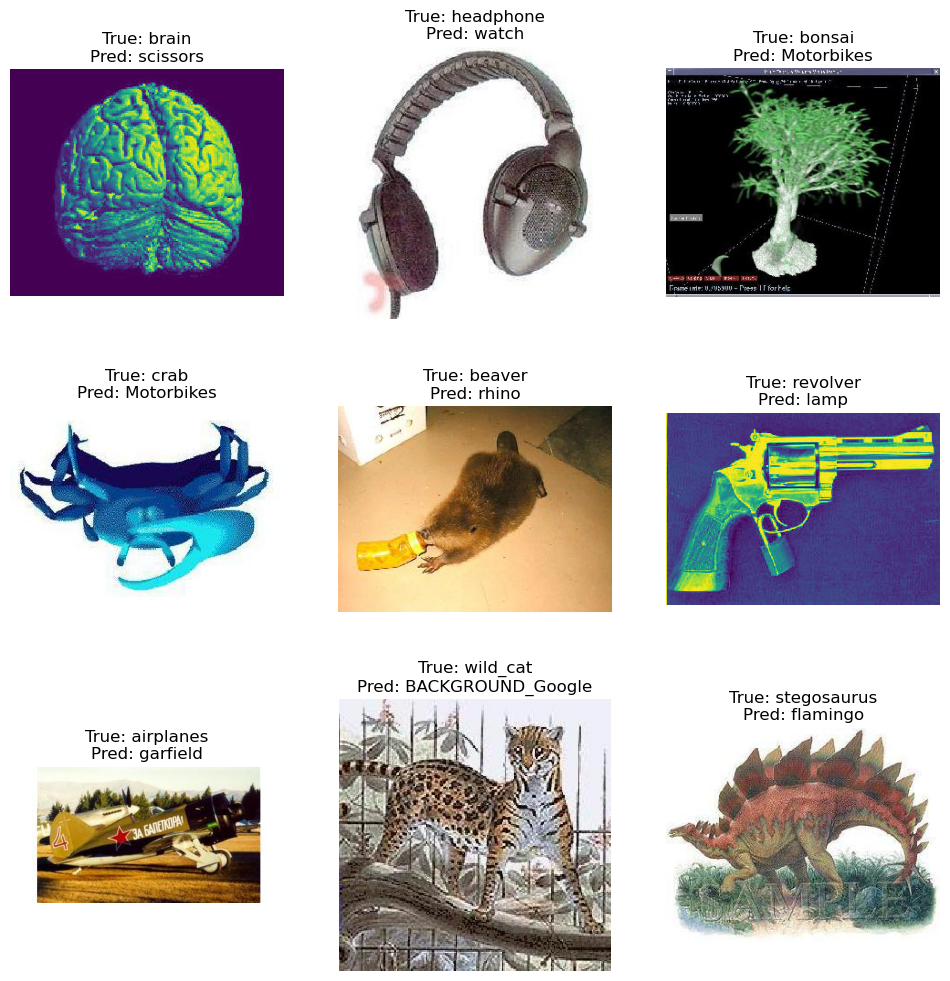

In [17]:
errors = np.where(y_pred != y_true)[0]
random_errors = np.random.choice(errors, 9)

plt.figure(figsize=(12,12))
for i, idx in enumerate(random_errors):
    img_path = val_gen.filepaths[idx]
    img = Image.open(img_path)

    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f"True: {classes[y_true[idx]]}\nPred: {classes[y_pred[idx]]}")
    plt.axis("off")
plt.show()



Dans ce projet, nous avons exploré le dataset Caltech-101, qui contient une variété d'images classées en différentes catégories. Nous avons suivi plusieurs étapes clés :

1. **Préparation des données** : Nous avons téléchargé et extrait le dataset, puis vérifié la structure des dossiers pour nous assurer que les images étaient correctement organisées.

2. **Visualisation des données** : Nous avons affiché des exemples d'images pour observer la variabilité visuelle au sein des différentes classes. Cela nous a permis de mieux comprendre les défis potentiels liés à la classification.

3. **Prétraitement des images** : Nous avons redimensionné les images à une taille uniforme et normalisé les pixels pour stabiliser l'entraînement des modèles.

4. **Modélisation** : Nous avons construit et entraîné deux modèles de classification d'images : un Perceptron Multicouche (MLP) et un Réseau de Neurones Convolutifs (CNN). Le CNN a montré de meilleures performances en raison de sa capacité à capturer des caractéristiques spatiales dans les images.

5. **Évaluation des performances** : Nous avons utilisé une matrice de confusion pour évaluer les performances du modèle CNN, ce qui nous a permis d'identifier les classes mal classées et d'analyser les erreurs.

6. **Analyse des erreurs** : Nous avons affiché des exemples d'images mal classées pour mieux comprendre les limites de notre modèle et identifier des pistes d'amélioration.

En conclusion, ce projet a démontré l'efficacité des CNN pour la classification d'images, tout en soulignant l'importance d'une bonne préparation des données et d'une analyse approfondie des résultats. Des améliorations futures pourraient inclure l'expérimentation avec des techniques d'augmentation de données, l'optimisation des hyperparamètres et l'exploration de modèles plus complexes pour améliorer encore les performances.